# New York City Taxi Fare Prediction

Can you predict a rider's taxi fare?

Kaggle competition hosted at https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

In [28]:
# Notebook preparation

import os, sys
sys.path.append(os.path.abspath('..'))

import numpy as np
import pandas
import matplotlib.pyplot as plt
from datetime import datetime
import glob
from h3 import h3
import shapely.geometry
import geopandas
import folium
import branca
import pickle

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('font', size=20)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import src.load_data

## Description

In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used (see the starter code for an example of this approach in Kernels). Your challenge is to do better than this using Machine Learning techniques!

The dataset contains information about taxi rides in New York City, including the location of the pickup and dropoff points, the timestamp at the start of the ride (but not the timestamp at the end) and the number of passengers. All of these pieces of information may be known in advance of the ride (the rider generally must include the intended dropoff point when calling the taxi using an app, although this information might be unknown if a rider is calling a taxi directly on the street). When the full information is known, the driver can use the expected fare amout to help decide if he/she wants to accept the ride.

## Provided dataset

The training dataset contains about 55 million rides, covering a 6.5-year period (from January 2009 to June 2015), as will be seen in the initial exploration, for an average of 23k rides per day. Given the population of the New York City region and the fact that taxis are quite popular there, this is probably just a sample and not a complete dataset. The provided test dataset contains a little less than 10k examples, covering the same period as the training dataset, which suggests that there is not a time-series structure to this problem. Because of the number of examples in the test dataset is so much smaller than the number of training, and the purpose of this project is not to participate in the official competition, we can disregard the provided test dataset and treat a portion of the training dataset as a test dataset (with the bonus of being able to immediately check the performance of the model).

The training dataset is a CSV file with around 5 GB. Processsing this information in one go (using Pandas for example) may be difficult on a standard computer that has 8 or 16 GB of RAM memory. One alternative is to use cloud clustes with bigger resources, but a different approach is to divide the file in smaller pieces and work with the whole dataset only when it is beneficial to do so. We decided to follow this second approach, which is implemented in a custom script, callable in a Makefile. The recipe is 

```
make parse_data
```

This uses a combination of Bash and Python commands to create relatively small Parquet files. This was tested on a standard laptop with 16 GB of RAM and ran without major issues in terms of excessive CPU or RAM use. We provide a method to list the Parquet files tha were created in this process.

In [29]:
files = {}
files['train'], files['test'] = src.load_data.get_data_files()
print('Number of files in training dataset: {}'.format(len(files['train'])))
print('Number of files in test dataset: {}'.format(len(files['test'])))

Number of files in training dataset: 56
Number of files in test dataset: 1


## External datasets


One of the main features about each ride is the location of the pickup and dropoff points, provided as geographical coordinates (latitude and longitude). Instead of using only the numerical values of the coordinates, we can try to aassociate them with known points or regions in the physical world. In the case of New York City, the city is famously divided in five boroughs (Manhattan, Queens, Brooklyn, Bronx and Staten Island), with the boundary between different boroughs usually marked by bodies of water. Then, the information about the pickup and dropoff boroughs can be useful because a ride between different boroughs may include a bridge or tunnel, which are chokepoints that may delay the trip and increase the fare.

We searched around and found this website (https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page) that makes available several different maps of NYC, divided according to political and administrative boundaries (in addition to the five boroughs). We created a process to automatically download these boundaries and pre-process them. The recipe for this is

```
make download_geojson
``` 

To help work with this information, we found the H3 package (https://h3geo.org/) useful. This package was created by Uber and encodes geographical information in a hierarchical structure based on hexagons. Each hexagon can be indexed by a 64-bit object (usually represented as a hexadecimal string) and a point can be represented by the smallest hexagons (which are roughly 1 meter in side   length, a resolution that is well suited to the problem of car navigation around a city). Areas can be represented by a list of hexagons. All geographical operations (such as checking if a point is inside a region) can be translated in terms of operations on the hexagon indices.

Part of the above script converts the information about areas to the H3 representation, while another script was created to convert the information about each ride in the train and test datasets. The recipe for this is

```
make process_hexagons
```

This creates extra files containing only the H3 representation of the pickup and dropoff points. It needs to be merged with the main dataset to have the full information about each ride.

These pieces of information can be combined to find out in which regions a given ride started and ended. In principle, we can use any of the divisions that we found in the official NYC website. Initially, we chose to focus on two divisions, the borough (because of its importance) and the State Assembly districts, because the level of granularity they provide (65 divisions) seems to be a good balance. The recipe for this is

```
make process_location LOCATION_TYPE=borough_shoreline
make process_location LOCATION_TYPE=state_assembly_shoreline
```

In principle, this information could be calculated just-in-time if a model needs it. However, it is a relatively expensive computation that results in a relatively small dataset, so there is a favorable tradeoff in terms of computing it once for the available datasets and caching the result.

## Exploration - Timestamp information

As a first step in exploration, I check when the rides happened, grouping by day.

In [30]:
def group_by_day(df):
    df['day'] = df['pickup_datetime'].dt.floor('d')
    df_out = df.groupby(['day']).agg({'key': 'count'}).rename(columns={'key': 'count'})
    return df_out.reset_index()

df_day = (
    pandas.concat((group_by_day(pandas.read_parquet(x)) for x in files['train']))
    .groupby(['day'], as_index=False)
    .agg({'count': 'sum'})
)

In [31]:
df_day.head()

,day,count
0,2009-01-01,16707
1,2009-01-02,18785
2,2009-01-03,21546
3,2009-01-04,18260
4,2009-01-05,19215


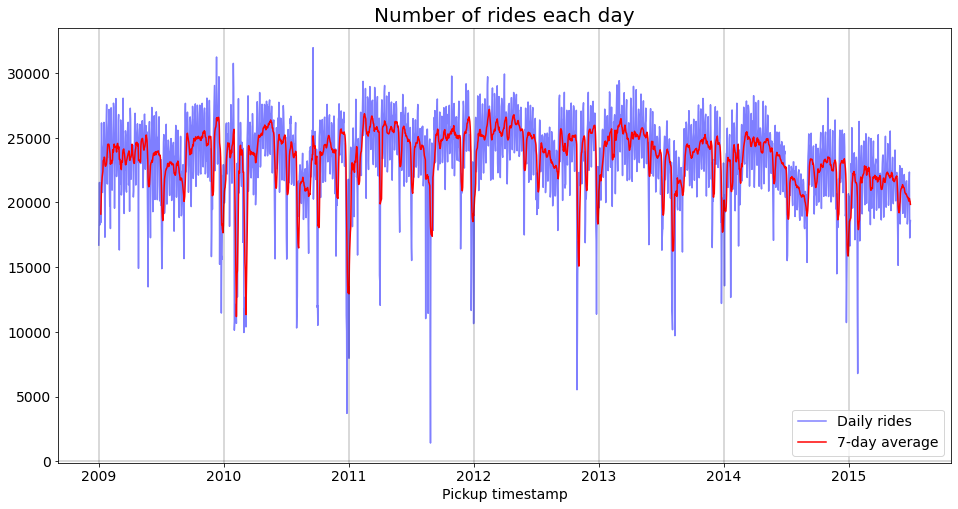

In [32]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df_day['day'], df_day['count'], 'b-', alpha=0.5, label='Daily rides')
ax.plot(df_day['day'], df_day['count'].rolling(7).mean(), 'r-', label='7-day average')
ax.axhline(0, color='k', alpha=0.2);
for year in range(2009, 2016):
    ax.axvline(datetime(year, 1, 1), color='k', alpha=0.2);
ax.set_xlabel('Pickup timestamp', fontsize=14);
ax.set_title('Number of rides each day', fontsize=20);
ax.legend(loc='lower right', fontsize=14);


There is no obvious long-term trend in the number of available rides in the dataset. There is a strong weekly seasonality and a small yearly seasonality. 

### Timezone issue

I found an issue with this feature, because the CSV says that the timestamps are in UTC timezone but I strongly suspect that it's actually local time. This was evident when I tried to check the quantity of rides per hour within a week.

In [33]:
%%time
def group_by_hour_int(df):
    df['hour'] = df['pickup_datetime'].dt.floor('h')
    df_out = df.groupby(['hour'], as_index=False).agg({'key': 'count'}).rename(columns={'key': 'count'})
    df_out['hour_int'] = df_out['hour'].apply(convert_hour_int)
    df_out = df_out.groupby(['hour_int']).agg({'count': 'sum'})
    return df_out.reset_index()

def convert_hour_int(ts):
    weekday, hour = ts.strftime('%w-%H').split('-')
    weekday = (int(weekday) - 1) % 7
    return 24*int(weekday) + int(hour)

df_hour = (
    pandas.concat((group_by_hour_int(pandas.read_parquet(x)) for x in files['train']))
    .groupby(['hour_int'], as_index=False)
    .agg({'count': 'sum'})
)

CPU times: user 52.8 s, sys: 8.99 s, total: 1min 1s
Wall time: 49.4 s


In [34]:
df_hour.head()

,hour_int,count
0,0,179892
1,1,110684
2,2,73417
3,3,51457
4,4,50986


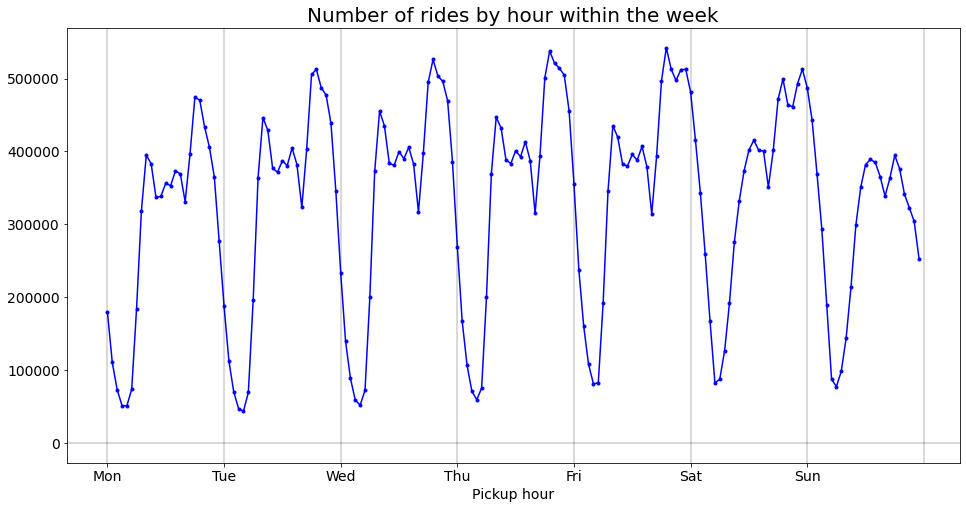

In [35]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df_hour['hour_int'], df_hour['count'], 'b.-')
ax.axhline(0, color='k', alpha=0.2);
for day in range(8):
    ax.axvline(24*day, color='k', alpha=0.2);
ax.set_xticks([24*x for x in range(7)])
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_xlabel('Pickup hour', fontsize=14);
ax.set_title('Number of rides by hour within the week', fontsize=20);


The lowest amount of activity happens between 03:00 and 05:00 each day, and a little later than that on the weekend. This is consistent with the timestamp being in local time. If the timestamp was indeed in UTC (which is 4 or 5 hours ahead of NYC local time depending on Daylight Saving Time), the period of lowest activity would be around 22:00 to midnight in local time, which does not make sense. 

Another way of checking that it is indeed local time is to check what happens on days that there was a Daylight Saving Time switch.

In [36]:
def find_DST_switch(timezone, date_start, date_end):
    df = pandas.DataFrame()
    df['day'] = pandas.date_range(date_start, date_end)
    df['hour_local'] = df['day']
    df['hour_local'] = df['hour_local'].dt.tz_localize(timezone)
    df['hour_utc'] = df['hour_local'].dt.tz_convert('UTC')
    df['offset'] = (
        df['hour_local'].dt.tz_localize(None) - df['hour_utc'].dt.tz_localize(None)
    ).apply(lambda x: x.total_seconds()/3600)
    df['changed'] = (df['offset'] - df['offset'].shift(-1)).isin([1, -1])
    return df.dropna().query('changed')

def group_by_hour(df, days):
    flter = df['pickup_datetime'].dt.floor('d').isin(days)
    dff = df[flter]
    dff['hour'] = dff['pickup_datetime'].dt.floor('h')
    df_out = dff.groupby(['hour']).agg({'key': 'count'}).rename(columns={'key': 'count'})
    return df_out.reset_index()

switch_days = find_DST_switch('America/New_York', datetime(2009,1,1), datetime(2016,1,1))['day']
df_switch = (
    pandas.concat((group_by_hour(pandas.read_parquet(x), switch_days) for x in files['train']))
    .groupby(['hour'], as_index=False)
    .agg({'count': 'sum'})
)

In [37]:
df_switch.head(5)

,hour,count
0,2009-03-08 00:00:00,1588
1,2009-03-08 01:00:00,1169
2,2009-03-08 02:00:00,300
3,2009-03-08 03:00:00,957
4,2009-03-08 04:00:00,896


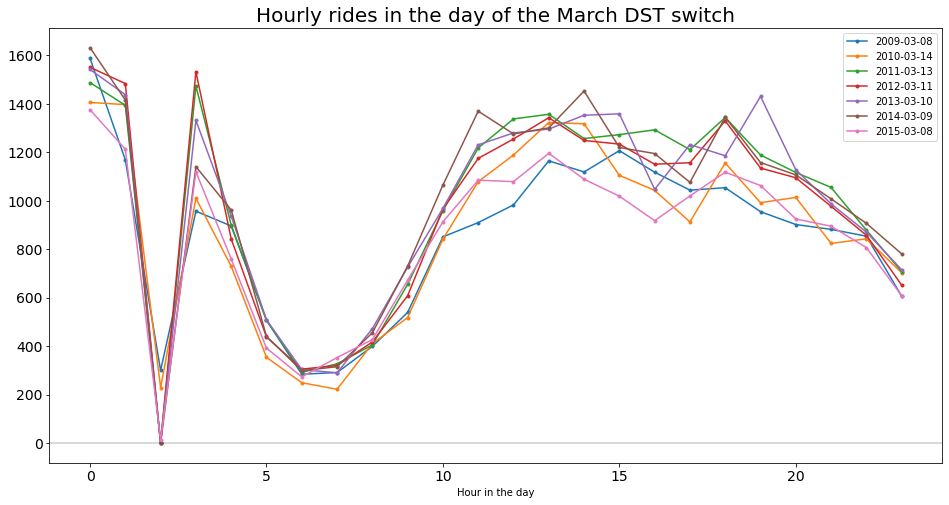

In [38]:
fig, ax = plt.subplots(figsize=(16, 8))
for day in switch_days:
    if day.month == 3:
        this = df_switch[df_switch['hour'].dt.floor('d')==day]
        if len(this) == 0:
            continue
        this['hour_int'] = (this['hour'] - day).apply(lambda x: x.total_seconds()/3600)
        this = (
            pandas.DataFrame(range(24), columns=['hour_int'])
            .merge(this, on=['hour_int'], how='left')
            .fillna({'count': 0})
        )
        ax.plot(this['hour_int'], this['count'], '.-', label=day.strftime('%Y-%m-%d'))
ax.legend();
ax.axhline(0, color='k', alpha=0.2);
ax.set_title('Hourly rides in the day of the March DST switch', fontsize=20)
ax.set_xlabel('Hour in the day');

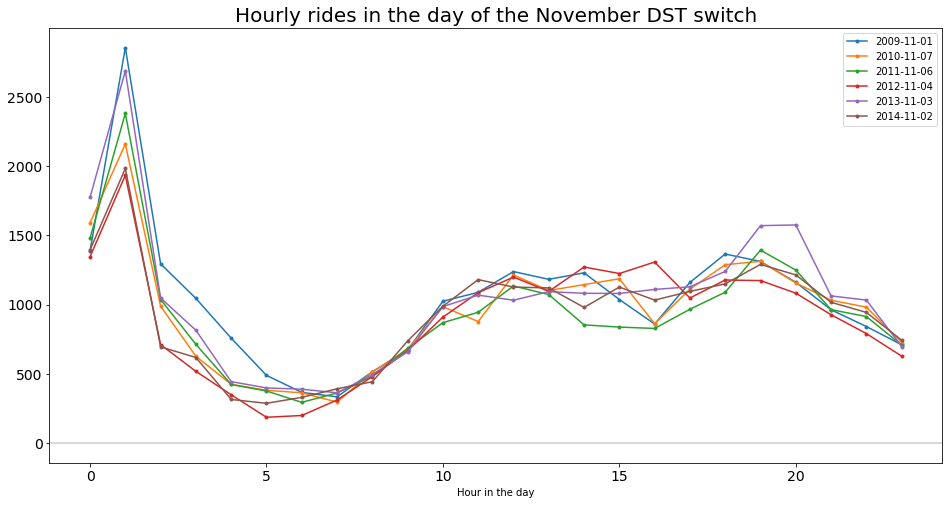

In [39]:
fig, ax = plt.subplots(figsize=(16, 8))
for day in switch_days:
    if day.month == 11:
        this = df_switch[df_switch['hour'].dt.floor('d')==day]
        if len(this) == 0:
            continue
        this['hour_int'] = (this['hour'] - day).apply(lambda x: x.total_seconds()/3600)
        this = (
            pandas.DataFrame(range(24), columns=['hour_int'])
            .merge(this, on=['hour_int'], how='left')
            .fillna({'count': 0})
        )
        ax.plot(this['hour_int'], this['count'], '.-', label=day.strftime('%Y-%m-%d'))
ax.legend();
ax.axhline(0, color='k', alpha=0.2);
ax.set_title('Hourly rides in the day of the November DST switch', fontsize=20)
ax.set_xlabel('Hour in the day');

In the March DST switch, I see that there are very few rides starting between 2:00 and 3:00. This hour does not exist in local time (clocks go from 1:59 to 3:00), and the few examples that appear may be related to inconsistent logging when a ride is active during the switch. On the other hand, in the November switch I see a large number of rides between 1:00 and 2:00, roughly twice what I would expect, because this hour occurs twice in local time (clocks go from 1:59 to 1:00).

In [40]:
del df_day, df_hour

## Exploration - Fare amount

The target variable for the current project is the fare amount, in dollars. Here we investigate its distribution. A vast majority of rides (around 90 %) cost less than 20 dollars. Some rides are shown with negative prices or very high prices (more than 100 USD), but they represent a very small fraction.

In [41]:
df_fare = (
    pandas.concat((pandas.read_parquet(x)[['fare_amount']] for x in files['train']))
)

In [42]:
(df_fare['fare_amount']<0).value_counts(normalize=True)

False    0.999956
True     0.000044
Name: fare_amount, dtype: float64

In [43]:
(df_fare['fare_amount']>100).value_counts(normalize=True)

False    0.999623
True     0.000377
Name: fare_amount, dtype: float64

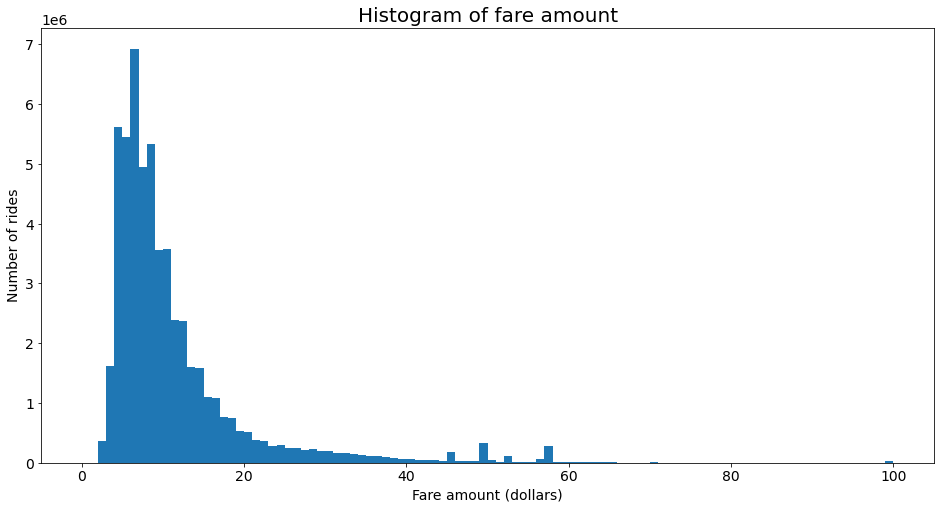

In [44]:
fig, ax = plt.subplots(figsize=(16, 8))
np.maximum(np.minimum(df_fare['fare_amount'], 100), 0).plot.hist(bins=100, ax=ax)
ax.set_title('Histogram of fare amount', fontsize=20);
ax.set_xlabel('Fare amount (dollars)', fontsize=14);
ax.set_ylabel('Number of rides', fontsize=14);

In [45]:
np.maximum(np.minimum(df_fare['fare_amount'], 100), 0).quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

0.01     3.30
0.05     4.10
0.25     6.00
0.50     8.50
0.75    12.50
0.90    20.50
0.95    30.33
0.99    53.00
Name: fare_amount, dtype: float64

In [46]:
del df_fare

## Exploration - Passenger count


The dataset provides the number of passengers in the ride. This is often a small number, with 70% of all rides having just one passenger. There are a few outliers in the data, which were eliminated in the visualization by treating every ride with 10+ passengers as having exactly 10. As we can see, there is a very small number of rides in this scenario.

In [47]:
df_passenger = (
    pandas.concat((pandas.read_parquet(x)[['passenger_count']] for x in files['train']))
)

In [48]:
np.quantile(df_passenger['passenger_count'], [0, 0.01, 0.5, 0.99, 1.0])

array([  0.,   1.,   1.,   6., 208.])

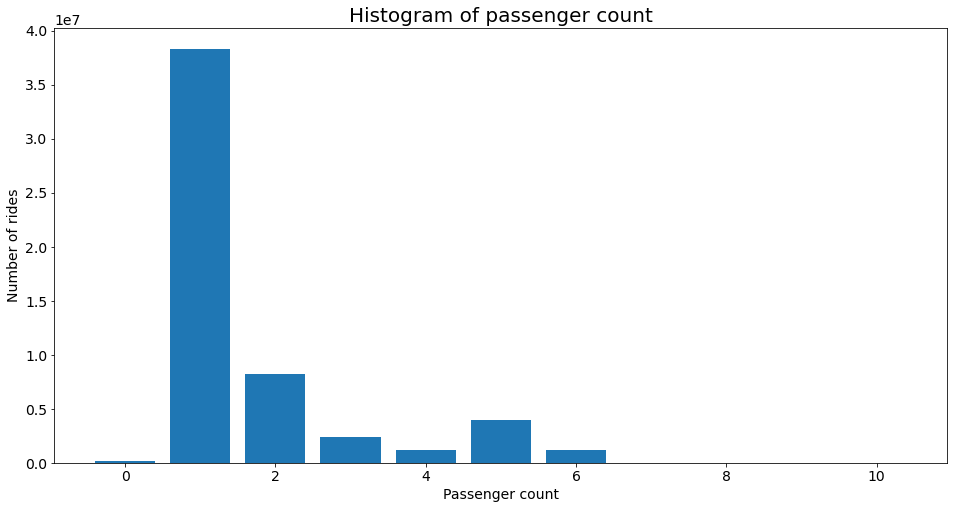

In [49]:
fig, ax = plt.subplots(figsize=(16, 8))
count = df_passenger.assign(
    key=1,
    passenger_count=lambda df: np.minimum(df['passenger_count'], 10)
).groupby(['passenger_count']).agg({'key': 'count'}).rename(columns={'key': 'count'})
ax.bar(count.index, count['count'])
ax.set_title('Histogram of passenger count', fontsize=20);
ax.set_xlabel('Passenger count', fontsize=14);
ax.set_ylabel('Number of rides', fontsize=14);

In [50]:
del df_passenger

## Exploration - Geographical distance

One important property of a taxi ride is the distance it covers, since longer rides tend to have higher fares. One cheap feature to calculate is the straight-line distance, which is not really the appropriate distance measures but can be a good approximation. This is calculated by the Haversine formula, but implemented by hand in order to use native Numpy methods. A more appropriate distance measure would take into account the road network and the path that a car must actually follow. This distance could be calculated by external paid APIs (such as Google Maps) or by downloading data from open mapping services like OpenStreetMaps. At this moment we will not pursue this strategy since it is either too expensive or too complicated for the scope of this project.

We plot a histogram of the obtained distances, capping all distances at a maximum of 50 km (so longer rides appear as it it was 50 km for the purposes of this histogram). We see a small peak there, representing about 0.2 % of all rides, that are likely due to errors in data logging. The vast majority of rides cover less than 10 km and there is a small bump of rides covering around 20 km, which may be related to trips between Manhattan and an airport.


In [51]:
def get_distance(df):
    flter = (
        (df['pickup_latitude']>-90) & (df['pickup_latitude']<90)
        & (df['pickup_longitude']>-180) & (df['pickup_longitude']<180)
        & (df['dropoff_latitude']>-90) & (df['dropoff_latitude']<90)
        & (df['dropoff_longitude']>-180) & (df['dropoff_longitude']<180)
    )
    diff_lat = (df.loc[flter, 'pickup_latitude'] - df.loc[flter, 'dropoff_latitude'])
    auxA = np.sin(diff_lat*np.pi/360)**2
    cos_lat1 = np.cos(df.loc[flter, 'pickup_latitude']*np.pi/180)
    cos_lat2 = np.cos(df.loc[flter, 'dropoff_latitude']*np.pi/180)
    diff_lon = (df.loc[flter, 'pickup_longitude'] - df.loc[flter, 'dropoff_longitude']) 
    auxB = cos_lat1 * cos_lat2 * np.sin(diff_lon*np.pi/360)**2
    dist_frac = 2*np.arcsin(np.sqrt(auxA + auxB))
    dist = (6.371e3)*dist_frac
    df.loc[flter, 'distance'] = dist
    return df[['distance']]

df_distance = (
    pandas.concat((get_distance(pandas.read_parquet(x)) for x in files['train']))
)

In [52]:
df_distance.head()

,distance
17882963382309193407,1.030742
3761969901288812763,8.450001
15046644836641625326,1.389632
13474184779486191885,2.799211
4125265812094162393,1.999081


In [53]:
(df_distance['distance']>50).value_counts(normalize=True)

False    0.997601
True     0.002399
Name: distance, dtype: float64

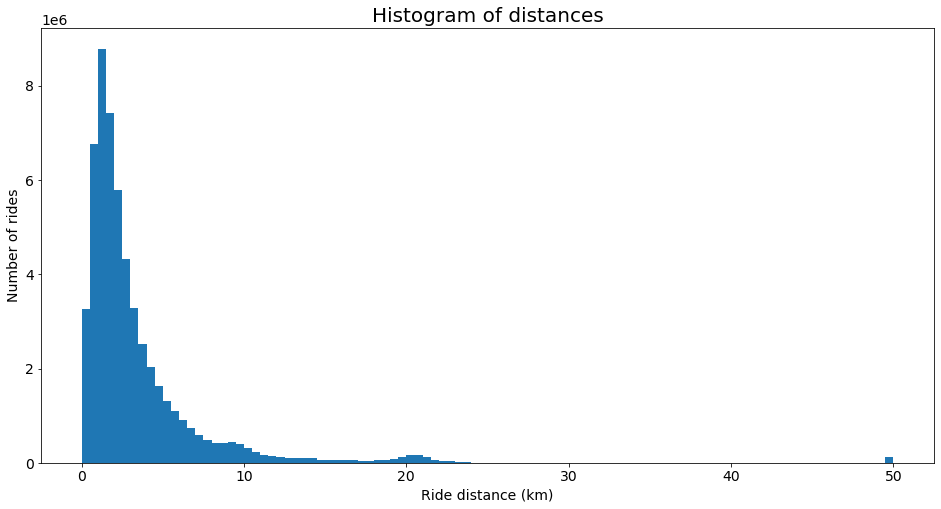

In [54]:
fig, ax = plt.subplots(figsize=(16, 8))
np.minimum(df_distance['distance'], 50).plot.hist(bins=100, ax=ax)
ax.set_title('Histogram of distances', fontsize=20);
ax.set_xlabel('Ride distance (km)', fontsize=14);
ax.set_ylabel('Number of rides', fontsize=14);

In [55]:
del df_distance

## Exploration - Geographical heat-map 


Having transformed the geographical coordinate into their H3 representation, we can count the number of trips originating or ending in a given hexagon (choosing appropriately the granularity level). This allows us to create a geographical heat map to visualize the regions with stronger taxi demand. These maps are saved into separate HTML files; it is possible to include them directly in the notebook, but sometimes they can be quite heavy and slow. Both the pickup and dropoff coordinates were plotted separately and we did not see any obvious difference in their pattern, although there could be a difference if we made some time-based slicings (for example, focusing only on morning rides, or evening rides, might show patterns of areas that are business-heavy or residential-heavy).

We could see from these maps that there is a large concentration of rides in Manhattan, especially to the south of Central Park. There could be a bias in data gathering (for instance, if this data was provided by a company that focuses on this particular area), but from what we know more generally about NYC this area is home to a number of significant businesses and touristic attractions, so it makes sense to be the area with the highest amount of taxi traffic. Outside of Manhattan, we found two other regions with significant traffic, that corresponds to the airports of LaGuardia and JFK (with significant more rides around LaGuardia than around JFK). We also see that the rides are not restricted to New York City, with a number of rides extending even to other neighbouring states (like New Jersey).

In [56]:
resolution = 9
def group_by_hexagon(df, endpoint, resolution=resolution):
    column = endpoint + '_hexagon'
    df[column+'_gr'] = df[column].apply(lambda h: int(h3.h3_to_parent(hex(h)[2:], resolution), 16) if h>0 else 0)
    df_out = df[df[column]>0].assign(key=1).groupby(column+'_gr').agg({'key': 'count'}).rename(columns={'key': 'count'})
    return df_out.reset_index()

def hexagon_to_shape(hex_index):
    coords = h3.h3_to_geo_boundary(hex(hex_index)[2:], geo_json=True)
    shape = shapely.geometry.shape({
        'type': 'Polygon',
        'coordinates': [[x[::1] for x in coords]],
    })
    return shape

fls = glob.glob(os.path.join(src.load_data.DATA_FOLDER, 'refined/hexagon*train*.parquet'))

In [57]:
df_hexagon_pickup = (
    pandas.concat(group_by_hexagon(pandas.read_parquet(x), 'pickup') for x in fls)
    .groupby(['pickup_hexagon_gr'], as_index=False)
    .agg({'count': 'sum'})
)
df_hexagon_pickup['geometry'] = df_hexagon_pickup['pickup_hexagon_gr'].apply(hexagon_to_shape)
df_geo_pickup = geopandas.GeoDataFrame(df_hexagon_pickup)

In [58]:
df_hexagon_dropoff = (
    pandas.concat(group_by_hexagon(pandas.read_parquet(x), 'dropoff') for x in fls)
    .groupby(['dropoff_hexagon_gr'], as_index=False)
    .agg({'count': 'sum'})
)
df_hexagon_dropoff['geometry'] = df_hexagon_dropoff['dropoff_hexagon_gr'].apply(hexagon_to_shape)
df_geo_dropoff = geopandas.GeoDataFrame(df_hexagon_dropoff)

In [59]:
mapp = folium.Map((40.78, -73.96), zoom_start=10)
rounding = int(1e4)
max_scale = np.quantile(df_geo_pickup['count'], [0.999])[0]
cmap = branca.colormap.linear.YlOrRd_09.scale(0, rounding*(1 + (max_scale//rounding)))
folium.GeoJson(
    df_geo_pickup.__geo_interface__,
    style_function = lambda ft: dict(
        fillOpacity=1,
        fillColor=cmap(ft['properties']['count'])[:7],
        weight=0.0,
    ),
    name='Pickup points',
).add_to(mapp)
cmap.add_to(mapp)
folium.LayerControl().add_to(mapp)
mapp.save('heatmap_pickup.html')

In [60]:
mapp = folium.Map((40.78, -73.96), zoom_start=10)
rounding = int(1e4)
max_scale = np.quantile(df_geo_dropoff['count'], [0.999])[0]
cmap = branca.colormap.linear.YlOrRd_09.scale(0, rounding*(1 + (max_scale//rounding)))
folium.GeoJson(
    df_geo_dropoff.__geo_interface__,
    style_function = lambda ft: dict(
        fillOpacity=1,
        fillColor=cmap(ft['properties']['count'])[:7],
        weight=0.0,
    ),
    name='Dropoff points',
).add_to(mapp)
cmap.add_to(mapp)
folium.LayerControl().add_to(mapp)
mapp.save('heatmap_dropoff.html')

In [61]:
del df_hexagon_pickup, df_geo_pickup, df_hexagon_dropoff, df_geo_dropoff

## Exploration - Regional information


Having translated the pickup and dropoff locations into political and administrative boundaries, I can count the number of trips that happen between each pair of regions. However, there is a strong concentration of rides on specific areas.

In terms of boroughs, approximately 86 % of all trips start and end in Manhattan, while another 10 % have one of its endpoints in Manhattan. This means that less than 5 % of trips do not involve Manhattan. In terms of State Assembly districts, which provide more spatial granularity, there is a similar pattern with 4 districts (located within Manhattan) concentrating a majority of rides (50 % of rides have both endpoints within the districts, and another 35 % have one endpoint).

In [62]:
def group_by_region_pair(df, region_id):
    columns = [x + '_' + region_id for x in ['pickup', 'dropoff']]
    df_out = df.assign(key=1).groupby(columns).agg({'key': 'count'}).rename(columns={'key': 'count'})
    return df_out.reset_index()

fls = glob.glob(os.path.join(src.load_data.DATA_FOLDER, 'refined/borough*train*.parquet'))
region_id = 'BoroName'
df_borough_pair = (
    pandas.concat((group_by_region_pair(pandas.read_parquet(x), region_id) for x in fls))
    .groupby([x + '_' + region_id for x in ['pickup', 'dropoff']], as_index=False)
    .agg({'count': 'sum'})
)

In [63]:
df_borough_pair.head()

,pickup_BoroName,dropoff_BoroName,count
0,Bronx,Bronx,35496
1,Bronx,Brooklyn,407
2,Bronx,Manhattan,12679
3,Bronx,Queens,1477
4,Bronx,Staten Island,8


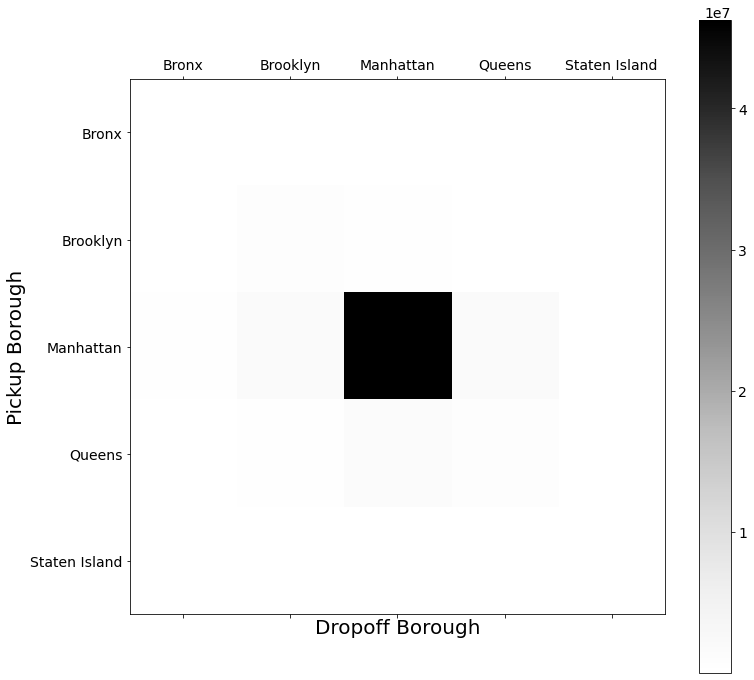

In [64]:
fig, ax = plt.subplots(figsize=(12, 12))
df_plt = pandas.pivot_table(
    df_borough_pair.reset_index(),
    index=['pickup_BoroName'],
    columns=['dropoff_BoroName'],
    values='count',
    aggfunc='sum',
    fill_value=0,
)
p = ax.matshow(df_plt, cmap='Greys')
plt.colorbar(p)
ax.set_xticks(range(len(df_plt.columns)));
ax.set_xticklabels(df_plt.columns);
ax.set_yticks(range(len(df_plt.index)));
ax.set_yticklabels(df_plt.index);
ax.set_xlabel('Dropoff Borough', fontsize=20);
ax.set_ylabel('Pickup Borough', fontsize=20);


In [65]:
fls = glob.glob(os.path.join(src.load_data.DATA_FOLDER, 'refined/state_assembly*train*.parquet'))
region_id = 'AssemDist'
df_district_pair = (
    pandas.concat((group_by_region_pair(pandas.read_parquet(x), region_id) for x in fls))
    .groupby([x + '_' + region_id for x in ['pickup', 'dropoff']], as_index=False)
    .agg({'count': 'sum'})
)

In [66]:
df_district_pair.head()

,pickup_AssemDist,dropoff_AssemDist,count
0,23.0,23.0,1247
1,23.0,24.0,22
2,23.0,25.0,6
3,23.0,26.0,6
4,23.0,27.0,21


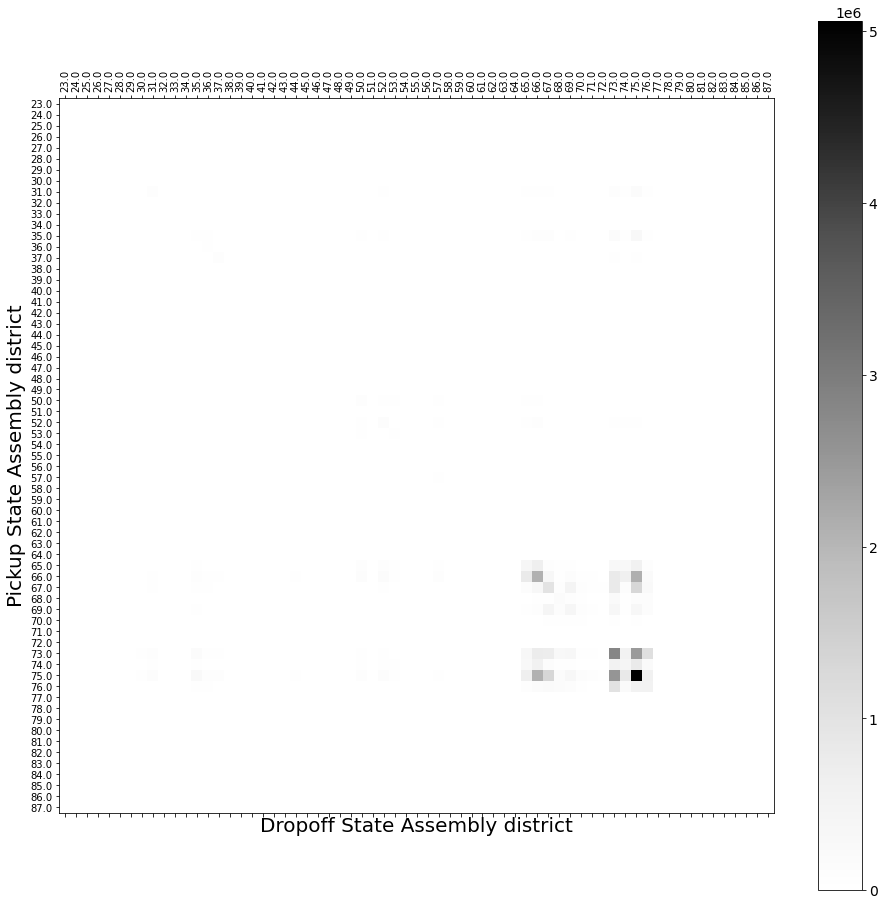

In [67]:
fig, ax = plt.subplots(figsize=(16, 16))
df_plt = pandas.pivot_table(
    df_district_pair.reset_index(),
    index=['pickup_AssemDist'],
    columns=['dropoff_AssemDist'],
    values='count',
    aggfunc='sum',
    fill_value=0,
)
p = ax.matshow(df_plt, cmap='Greys')
plt.colorbar(p)
ax.set_xticks(range(len(df_plt.columns)));
ax.set_xticklabels(df_plt.columns, fontsize=10, rotation=90);
ax.set_yticks(range(len(df_plt.index)));
ax.set_yticklabels(df_plt.index, fontsize=10);
ax.set_xlabel('Dropoff State Assembly district', fontsize=20);
ax.set_ylabel('Pickup State Assembly district', fontsize=20);


In [68]:
del df_borough_pair, df_district_pair

## Feature Engineering

After the initial exploration, I can build features that will be useful to our machine learning models. One typical approach would be to have all the features in one Pandas dataframe or Numpy array, but I will not follow this approach because the resulting file would be quite large (several GBs) and for specific models I may want to use only a subset of features. Lazy loading of dataset columns is supported by some frameworks (BigQuery, Spark on Parquet files) but not efficiently implemented in Pandas or Numpy. By saving each feature in a separate Numpy array (saved with pickle), I can implement by hand a form of lazy loading. One downside of this strategy is that the rows in every file must be in the same order (I could avoid this if I also stored an index with each feature, but merging datasets is a memory-hungry operation in Pandas and 16 GB of RAW was not enough to perform it).

The feature generating process was automated in the Makefile, with the recipe

```
make features
```

This script will generate a number of `.pickle` files, each of them containing a set of features. One important feature is `train_test_split`, where each observation has been divided in *three* groups.

* `status == 2` represent observations labeled as outliers. This might be because the coordinates are too far away from NYC, or the pickup and dropoff points are too far apart, or the fare amount is outside a reasonable range (negative values or very high values, above 100 USD). These observations will not be used for modelling. 
* `status == 0` are valid observations that form a training dataset (about 75 %).
* `status == 1` are valid observations that form a testing dataset (about 25 %).

The sci-kit learn framework usually works best when the training and test dataset are split in different files (technically they need to be split in different dataframes in memory). Because of this, I also included an script to create separate testing and test datasets (while also dropping the malformed examples). The recipe for this is 

```
make features_train_test_split EXAMPLES=<int>
```

I included in this script a parameter to limit the total number of examples. The reason for this is to speed up training and allow more rounds of iteration and experimentation with different strategies. Once a promising model architecture is found, I can go back and train it in more examples. 


In [69]:
prefix = src.load_data.DATA_FOLDER
fls = glob.glob(os.path.join(prefix, "features", "full", "*.pickle"))
for fl in sorted(fls):
    print('File: {}'.format(fl[len(prefix):].strip('/')))
    with open(fl, 'rb') as f:
        arr = pickle.load(f)
    print('Shape: {}'.format(arr.shape))

File: features/full/borough.pickle
Shape: (55423856, 2)
File: features/full/coordinates.pickle
Shape: (55423856, 4)
File: features/full/distance.pickle
Shape: (55423856, 1)
File: features/full/fare.pickle
Shape: (55423856, 1)
File: features/full/passenger_count.pickle
Shape: (55423856, 1)
File: features/full/primary_key.pickle
Shape: (55423856, 1)
File: features/full/state_assembly.pickle
Shape: (55423856, 2)
File: features/full/timestamp_week.pickle
Shape: (55423856, 1)
File: features/full/train_test_split.pickle
Shape: (55423856, 1)


In [70]:
prefix = src.load_data.DATA_FOLDER
fls = glob.glob(os.path.join(prefix, "features", "train", "*.pickle"))
for fl in sorted(fls):
    print('File: {}'.format(fl[len(prefix):].strip('/')))
    with open(fl, 'rb') as f:
        arr = pickle.load(f)
    print('Shape: {}'.format(arr.shape))

File: features/train/borough.pickle
Shape: (3630428, 2)
File: features/train/coordinates.pickle
Shape: (3630428, 4)
File: features/train/distance.pickle
Shape: (3630428, 1)
File: features/train/fare.pickle
Shape: (3630428, 1)
File: features/train/passenger_count.pickle
Shape: (3630428, 1)
File: features/train/primary_key.pickle
Shape: (3630428, 1)
File: features/train/state_assembly.pickle
Shape: (3630428, 2)
File: features/train/timestamp_week.pickle
Shape: (3630428, 1)
File: features/train/train_test_split.pickle
Shape: (3630428, 1)


In [71]:
prefix = src.load_data.DATA_FOLDER
fls = glob.glob(os.path.join(prefix, "features", "test", "*.pickle"))
for fl in sorted(fls):
    print('File: {}'.format(fl[len(prefix):].strip('/')))
    with open(fl, 'rb') as f:
        arr = pickle.load(f)
    print('Shape: {}'.format(arr.shape))

File: features/test/borough.pickle
Shape: (1210204, 2)
File: features/test/coordinates.pickle
Shape: (1210204, 4)
File: features/test/distance.pickle
Shape: (1210204, 1)
File: features/test/fare.pickle
Shape: (1210204, 1)
File: features/test/passenger_count.pickle
Shape: (1210204, 1)
File: features/test/primary_key.pickle
Shape: (1210204, 1)
File: features/test/state_assembly.pickle
Shape: (1210204, 2)
File: features/test/timestamp_week.pickle
Shape: (1210204, 1)
File: features/test/train_test_split.pickle
Shape: (1210204, 1)


## Modeling

I am now in position to create and train machine learning models. The goal is to predict the fare for a taxi ride, so it is more naturally stated as a regression problem, with a target variable that is always non-negative. The target distribution is skewed, with a right tail that is considerably longer than the left tail, even though I have applied a filter to remove examples that are far away to the right. One possible consequence of this assymetry is that different metrics (such as Mean Squared Error or Mean Absolute Error) may lead to different conclusions when comparing different models.

In the first moment, instead of focusing on different model architectures, I am going to focus on the impact of adding features. In particular, I shall use the features created from the external datasets and see how they can improve on the results compared with using only the information available in Kaggle. In order to compare models created with different feature sets, I am going a basic architecture of a TensorFlow neural network, with a ReLU unit as the output to avoid forecasting a negative value for the fare.

The comparison between models can be done with the help of Mlflow (https://www.mlflow.org/docs/latest/index.html). With Mlflow, I can log information about each run (of model fitting), including choices of parameters, resulting metrics, and even complete fitted models than can be later used to make further predictions in unseen data.

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    FunctionTransformer, PolynomialFeatures, RobustScaler, OneHotEncoder
)
import sklearn.metrics
import tensorflow as tf
import mlflow

import src.features.utils as ml_utils

2022-02-21 08:37:43.685916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-21 08:37:43.685993: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
mlflow.set_experiment('new_york_city_taxi')

<Experiment: artifact_location='file:///home/tiagobbatalhao/Documents/personal_repos/kaggle/new_york_taxi/notebooks/mlruns/1', experiment_id='1', lifecycle_stage='active', name='new_york_city_taxi', tags={}>

In [4]:
def get_base_model(**kwargs):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(1, activation='relu')
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse'],
    )
    return model

def get_metrics(model, features_test, target_test):
    pred = model.predict(features_test)
    metrics = {}
    metrics['R2'] = sklearn.metrics.r2_score(target_test, pred)
    metrics['RMSE'] = np.sqrt(sklearn.metrics.mean_squared_error(target_test, pred))
    metrics['MAE'] = sklearn.metrics.mean_absolute_error(target_test, pred)
    return metrics

class Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, *args, **kwargs):
        pass

    def fit(self, *args, **kwargs):
        return self

    def fit_transform(self, *args, **kwargs):
        return self.transform(*args, **kwargs)
    
class LoadFeature(Transformer):    
    def __init__(self, name):
        self.name = name
        
    def transform(self, files, *args, **kwargs):
        with open(files[self.name], 'rb') as f:
            arr = pickle.load(f)
        return arr
    
def coordinates_to_mercator(coordinates):
    mercator = np.zeros_like(coordinates)
    deg_to_rad = np.pi/180
    mercator[:, 0] = coordinates[:, 1]*deg_to_rad
    mercator[:, 1] = np.log(np.arctan(coordinates[:, 0]*deg_to_rad/2 + np.pi/4))
    return mercator


In [5]:
files_train = {}
data_folder = src.load_data.DATA_FOLDER
for fl in glob.glob(os.path.join(data_folder, 'features/train/*.pickle')):
    _, base = os.path.split(fl)
    name = base.split('.')[0]
    files_train[name] = fl
files_test = {}
for fl in glob.glob(os.path.join(data_folder, 'features/test/*.pickle')):
    _, base = os.path.split(fl)
    name = base.split('.')[0]
    files_test[name] = fl


### Baseline model

As a baseline model, I am going to use only features directly available in the Kaggle dataset.

In [27]:
def train_baseline_v0(epochs=3):
    output = {}
    output['feature_creator'] = FeatureUnion([
            ("distance", Pipeline([
                ("load", LoadFeature('distance')),
                ("scaler", RobustScaler()),
                ("polynomial", PolynomialFeatures(4, include_bias=False)),
            ])),
            ("passenger_count", Pipeline([
                ("load", LoadFeature('passenger_count')),
                ('clamp_outliers', FunctionTransformer(lambda arr: np.minimum(arr, 10))),
            ])),
            ("fourier_day", Pipeline([
                ("load", LoadFeature('timestamp_week')),
                ("fourier", ml_utils.FourierSeries(period=24, max_freq=4)),
            ])),
            ("week_day", Pipeline([
                ("load", LoadFeature('timestamp_week')),
                ('floor', FunctionTransformer(lambda arr: arr//24)),
            ])),
    ])
    output['target_creator'] = Pipeline([
        ("load", LoadFeature('fare')),
        ("reshape", FunctionTransformer(lambda arr: arr.reshape(-1))),
    ])
    output['model'] = get_base_model()

    output['features_train'] = output['feature_creator'].fit_transform(files_train)
    output['target_train'] = output['target_creator'].fit_transform(files_train)
    output['model'].fit(output['features_train'], output['target_train'], epochs=epochs)

    output['features_test'] = output['feature_creator'].transform(files_test)
    output['target_test'] = output['target_creator'].transform(files_test)
    output['metrics'] = get_metrics(
        output['model'],
        output['features_test'],
        output['target_test'],
    )
    return output

In [28]:
with mlflow.start_run():
    baseline_v0 = train_baseline_v0()
    mlflow.log_params({
        'strategy_name': 'baseline_v0',
        'features_train_shape': (baseline_v0['features_train'].shape),
        'features_test_shape': (baseline_v0['features_test'].shape),
    })
    mlflow.log_metrics(baseline_v0['metrics'])
    mlflow.sklearn.log_model(
        Pipeline([
            ('feature', baseline_v0['feature_creator']),
            ('model', baseline_v0['model']),
        ]),
        artifact_path='sklearn_pipeline_model',
    )
print(baseline_v0['metrics'])
del baseline_v0

Epoch 1/3
113451/113451 [==============================] - 186s 2ms/step - loss: 30931.6309 - mae: 2.4568 - mse: 30931.6309
Epoch 2/3
113451/113451 [==============================] - 185s 2ms/step - loss: 18.5532 - mae: 2.2890 - mse: 18.5532
Epoch 3/3
113451/113451 [==============================] - 186s 2ms/step - loss: 19030.4629 - mae: 2.3930 - mse: 19030.4629
INFO:tensorflow:Assets written to: ram://42c56b70-492f-4b4c-bed6-d14a632a9119/assets
{'R2': 0.7933198389574266, 'RMSE': 4.233554194561983, 'MAE': 2.2500377023393785}


In [29]:
def train_baseline_v1(epochs=3):
    output = {}
    output['feature_creator'] = FeatureUnion([
            ("distance", Pipeline([
                ("load", LoadFeature('distance')),
                ("scaler", RobustScaler()),
                ("polynomial", PolynomialFeatures(4, include_bias=False)),
            ])),
            ("passenger_count", Pipeline([
                ("load", LoadFeature('passenger_count')),
                ('clamp_outliers', FunctionTransformer(lambda arr: np.minimum(arr, 10))),
            ])),
            ("fourier_day", Pipeline([
                ("load", LoadFeature('timestamp_week')),
                ("fourier", ml_utils.FourierSeries(period=24, max_freq=4)),
            ])),
            ("week_day", Pipeline([
                ("load", LoadFeature('timestamp_week')),
                ('floor', FunctionTransformer(lambda arr: arr//24)),
            ])),
            ("coordinates", Pipeline([
                ("load", LoadFeature('coordinates')),
                ("to_mercator", FunctionTransformer(
                    lambda arr: np.concatenate([
                        coordinates_to_mercator(arr[:, 0:2]).T,
                        coordinates_to_mercator(arr[:, 2:4]).T,
                    ]).T,
                )),
                ("scaler", RobustScaler()),
            ])),
    ])
    output['target_creator'] = Pipeline([
        ("load", LoadFeature('fare')),
        ("reshape", FunctionTransformer(lambda arr: arr.reshape(-1))),
    ])
    output['model'] = get_base_model()

    output['features_train'] = output['feature_creator'].fit_transform(files_train)
    output['target_train'] = output['target_creator'].fit_transform(files_train)
    output['model'].fit(output['features_train'], output['target_train'], epochs=epochs)

    output['features_test'] = output['feature_creator'].transform(files_test)
    output['target_test'] = output['target_creator'].transform(files_test)
    output['metrics'] = get_metrics(
        output['model'],
        output['features_test'],
        output['target_test'],
    )
    return output

In [30]:
with mlflow.start_run():
    baseline_v1 = train_baseline_v1()
    mlflow.log_params({
        'strategy_name': 'baseline_v1',
        'features_train_shape': (baseline_v1['features_train'].shape),
        'features_test_shape': (baseline_v1['features_test'].shape),
    })
    mlflow.log_metrics(baseline_v1['metrics'])
    mlflow.sklearn.log_model(
        Pipeline([
            ('feature', baseline_v1['feature_creator']),
            ('model', baseline_v1['model']),
        ]),
        artifact_path='sklearn_pipeline_model',
    )
print(baseline_v1['metrics'])
del baseline_v1

Epoch 1/3
113451/113451 [==============================] - 188s 2ms/step - loss: 769.8999 - mae: 2.1666 - mse: 769.8999
Epoch 2/3
113451/113451 [==============================] - 187s 2ms/step - loss: 273.9091 - mae: 2.0561 - mse: 273.9091
Epoch 3/3
113451/113451 [==============================] - 187s 2ms/step - loss: 93.1204 - mae: 2.0486 - mse: 93.1204
INFO:tensorflow:Assets written to: ram://94e7af28-0f16-4d97-a889-efb23309a269/assets
{'R2': 0.8258575094339511, 'RMSE': 3.8860474903776425, 'MAE': 2.0301458610312317}


### Using external information

In [31]:
def train_external_v0(epochs=3):
    output = {}
    output['feature_creator'] = FeatureUnion([
            ("distance", Pipeline([
                ("load", LoadFeature('distance')),
                ("scaler", RobustScaler()),
                ("polynomial", PolynomialFeatures(4, include_bias=False)),
            ])),
            ("passenger_count", Pipeline([
                ("load", LoadFeature('passenger_count')),
                ('clamp_outliers', FunctionTransformer(lambda arr: np.minimum(arr, 10))),
            ])),
            ("fourier_day", Pipeline([
                ("load", LoadFeature('timestamp_week')),
                ("fourier", ml_utils.FourierSeries(period=24, max_freq=4)),
            ])),
            ("week_day", Pipeline([
                ("load", LoadFeature('timestamp_week')),
                ('floor', FunctionTransformer(lambda arr: arr//24)),
            ])),
            ("borough", Pipeline([
                ("load", LoadFeature('borough')),
                ("OHE", OneHotEncoder()),
            ])),
    ])
    output['target_creator'] = Pipeline([
        ("load", LoadFeature('fare')),
        ("reshape", FunctionTransformer(lambda arr: arr.reshape(-1))),
    ])
    output['model'] = get_base_model()

    output['features_train'] = output['feature_creator'].fit_transform(files_train)
    output['target_train'] = output['target_creator'].fit_transform(files_train)
    output['model'].fit(output['features_train'].todense(), output['target_train'], epochs=epochs)

    output['features_test'] = output['feature_creator'].transform(files_test)
    output['target_test'] = output['target_creator'].transform(files_test)
    output['metrics'] = get_metrics(
        output['model'],
        output['features_test'].todense(),
        output['target_test'],
    )
    return output

In [32]:
with mlflow.start_run():
    external_v0 = train_external_v0()
    mlflow.log_params({
        'strategy_name': 'external_v0',
        'features_train_shape': (external_v0['features_train'].shape),
        'features_test_shape': (external_v0['features_test'].shape),
    })
    mlflow.log_metrics(external_v0['metrics'])
    mlflow.sklearn.log_model(
        Pipeline([
            ('feature', external_v0['feature_creator']),
            ('model', external_v0['model']),
        ]),
        artifact_path='sklearn_pipeline_model',
    )
print(external_v0['metrics'])
del external_v0

Epoch 1/3
113451/113451 [==============================] - 189s 2ms/step - loss: 9393.0762 - mae: 2.3085 - mse: 9393.0762
Epoch 2/3
113451/113451 [==============================] - 188s 2ms/step - loss: 1525.4580 - mae: 2.2200 - mse: 1525.4580
Epoch 3/3
113451/113451 [==============================] - 189s 2ms/step - loss: 204.7287 - mae: 2.1630 - mse: 204.7287
INFO:tensorflow:Assets written to: ram://e2f21018-7438-4aa2-8efc-709b0397e6e6/assets
{'R2': 0.8234142889194732, 'RMSE': 3.9132131770134095, 'MAE': 2.120719488904192}


In [33]:
def train_external_v1(epochs=3):
    output = {}
    output['feature_creator'] = FeatureUnion([
            ("distance", Pipeline([
                ("load", LoadFeature('distance')),
                ("scaler", RobustScaler()),
                ("polynomial", PolynomialFeatures(4, include_bias=False)),
            ])),
            ("passenger_count", Pipeline([
                ("load", LoadFeature('passenger_count')),
                ('clamp_outliers', FunctionTransformer(lambda arr: np.minimum(arr, 10))),
            ])),
            ("fourier_day", Pipeline([
                ("load", LoadFeature('timestamp_week')),
                ("fourier", ml_utils.FourierSeries(period=24, max_freq=4)),
            ])),
            ("week_day", Pipeline([
                ("load", LoadFeature('timestamp_week')),
                ('floor', FunctionTransformer(lambda arr: arr//24)),
            ])),
            ("state_assembly", Pipeline([
                ("load", LoadFeature('state_assembly')),
                ("OHE", OneHotEncoder()),
            ])),
    ])
    output['target_creator'] = Pipeline([
        ("load", LoadFeature('fare')),
        ("reshape", FunctionTransformer(lambda arr: arr.reshape(-1))),
    ])
    output['model'] = get_base_model()

    output['features_train'] = output['feature_creator'].fit_transform(files_train)
    output['target_train'] = output['target_creator'].fit_transform(files_train)
    output['model'].fit(output['features_train'].todense(), output['target_train'], epochs=epochs)

    output['features_test'] = output['feature_creator'].transform(files_test)
    output['target_test'] = output['target_creator'].transform(files_test)
    output['metrics'] = get_metrics(
        output['model'],
        output['features_test'].todense(),
        output['target_test'],
    )
    return output

In [34]:
with mlflow.start_run():
    external_v1 = train_external_v1()
    mlflow.log_params({
        'strategy_name': 'external_v1',
        'features_train_shape': (external_v1['features_train'].shape),
        'features_test_shape': (external_v1['features_test'].shape),
    })
    mlflow.log_metrics(external_v1['metrics'])
    mlflow.sklearn.log_model(
        Pipeline([
            ('feature', external_v1['feature_creator']),
            ('model', external_v1['model']),
        ]),
        artifact_path='sklearn_pipeline_model',
    )
print(external_v1['metrics'])
del external_v1

Epoch 1/3


2022-02-21 00:03:15.463091: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2120169952 exceeds 10% of free system memory.


113451/113451 [==============================] - 210s 2ms/step - loss: 2161.6357 - mae: 2.1711 - mse: 2161.6357
Epoch 2/3
113451/113451 [==============================] - 209s 2ms/step - loss: 16.9715 - mae: 2.0725 - mse: 16.9715
Epoch 3/3
113451/113451 [==============================] - 209s 2ms/step - loss: 18.2987 - mae: 2.0721 - mse: 18.2987
INFO:tensorflow:Assets written to: ram://3d949d5b-da88-48c8-b5c8-e83ee9c44802/assets
{'R2': 0.8292207238314426, 'RMSE': 3.8483389133445374, 'MAE': 2.0322384294422546}


In [6]:
def train_external_v2(epochs=3):
    output = {}
    output['feature_creator'] = FeatureUnion([
            ("distance", Pipeline([
                ("load", LoadFeature('distance')),
                ("scaler", RobustScaler()),
                ("polynomial", PolynomialFeatures(4, include_bias=False)),
            ])),
            ("passenger_count", Pipeline([
                ("load", LoadFeature('passenger_count')),
                ('clamp_outliers', FunctionTransformer(lambda arr: np.minimum(arr, 10))),
            ])),
            ("fourier_day", Pipeline([
                ("load", LoadFeature('timestamp_week')),
                ("fourier", ml_utils.FourierSeries(period=24, max_freq=4)),
            ])),
            ("week_day", Pipeline([
                ("load", LoadFeature('timestamp_week')),
                ('floor', FunctionTransformer(lambda arr: arr//24)),
            ])),
            ("coordinates", Pipeline([
                ("load", LoadFeature('coordinates')),
                ("to_mercator", FunctionTransformer(
                    lambda arr: np.concatenate([
                        coordinates_to_mercator(arr[:, 0:2]).T,
                        coordinates_to_mercator(arr[:, 2:4]).T,
                    ]).T,
                )),
                ("scaler", RobustScaler()),
            ])),
            ("borough", Pipeline([
                ("load", LoadFeature('borough')),
                ("OHE", OneHotEncoder()),
            ])),
    ])
    output['target_creator'] = Pipeline([
        ("load", LoadFeature('fare')),
        ("reshape", FunctionTransformer(lambda arr: arr.reshape(-1))),
    ])
    output['model'] = get_base_model()

    output['features_train'] = output['feature_creator'].fit_transform(files_train)
    output['target_train'] = output['target_creator'].fit_transform(files_train)
    output['model'].fit(output['features_train'].todense(), output['target_train'], epochs=epochs)

    output['features_test'] = output['feature_creator'].transform(files_test)
    output['target_test'] = output['target_creator'].transform(files_test)
    output['metrics'] = get_metrics(
        output['model'],
        output['features_test'].todense(),
        output['target_test'],
    )
    return output

In [7]:
with mlflow.start_run():
    external_v2 = train_external_v2()
    mlflow.log_params({
        'strategy_name': 'external_v2',
        'features_train_shape': (external_v2['features_train'].shape),
        'features_test_shape': (external_v2['features_test'].shape),
    })
    mlflow.log_metrics(external_v2['metrics'])
    mlflow.sklearn.log_model(
        Pipeline([
            ('feature', external_v2['feature_creator']),
            ('model', external_v2['model']),
        ]),
        artifact_path='sklearn_pipeline_model',
    )
print(external_v2['metrics'])
del external_v2

2022-02-21 08:37:54.215679: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-21 08:37:54.215753: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-21 08:37:54.215823: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tiagobbatalhao-Latitude-3490): /proc/driver/nvidia/version does not exist
2022-02-21 08:37:54.217219: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/3
113451/113451 [==============================] - 203s 2ms/step - loss: 834.2234 - mae: 2.1316 - mse: 834.2234
Epoch 2/3
113451/113451 [==============================] - 199s 2ms/step - loss: 1504.9906 - mae: 2.0791 - mse: 1504.9906
Epoch 3/3
113451/113451 [==============================] - 244s 2ms/step - loss: 14.7901 - mae: 1.9961 - mse: 14.7901


2022-02-21 08:49:37.969430: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://ba2fc755-8b7c-4459-8ea7-920a73cb5ced/assets
{'R2': 0.8364179673064865, 'RMSE': 3.766374737917157, 'MAE': 1.9290000723513672}


In [8]:
def train_external_v3(epochs=3):
    output = {}
    output['feature_creator'] = FeatureUnion([
            ("distance", Pipeline([
                ("load", LoadFeature('distance')),
                ("scaler", RobustScaler()),
                ("polynomial", PolynomialFeatures(4, include_bias=False)),
            ])),
            ("passenger_count", Pipeline([
                ("load", LoadFeature('passenger_count')),
                ('clamp_outliers', FunctionTransformer(lambda arr: np.minimum(arr, 10))),
            ])),
            ("fourier_day", Pipeline([
                ("load", LoadFeature('timestamp_week')),
                ("fourier", ml_utils.FourierSeries(period=24, max_freq=4)),
            ])),
            ("week_day", Pipeline([
                ("load", LoadFeature('timestamp_week')),
                ('floor', FunctionTransformer(lambda arr: arr//24)),
            ])),
            ("coordinates", Pipeline([
                ("load", LoadFeature('coordinates')),
                ("to_mercator", FunctionTransformer(
                    lambda arr: np.concatenate([
                        coordinates_to_mercator(arr[:, 0:2]).T,
                        coordinates_to_mercator(arr[:, 2:4]).T,
                    ]).T,
                )),
                ("scaler", RobustScaler()),
            ])),
            ("state_assembly", Pipeline([
                ("load", LoadFeature('state_assembly')),
                ("OHE", OneHotEncoder()),
            ])),
    ])
    output['target_creator'] = Pipeline([
        ("load", LoadFeature('fare')),
        ("reshape", FunctionTransformer(lambda arr: arr.reshape(-1))),
    ])
    output['model'] = get_base_model()

    output['features_train'] = output['feature_creator'].fit_transform(files_train)
    output['target_train'] = output['target_creator'].fit_transform(files_train)
    output['model'].fit(output['features_train'].todense(), output['target_train'], epochs=epochs)

    output['features_test'] = output['feature_creator'].transform(files_test)
    output['target_test'] = output['target_creator'].transform(files_test)
    output['metrics'] = get_metrics(
        output['model'],
        output['features_test'].todense(),
        output['target_test'],
    )
    return output

In [9]:
with mlflow.start_run():
    external_v3 = train_external_v3()
    mlflow.log_params({
        'strategy_name': 'external_v3',
        'features_train_shape': (external_v3['features_train'].shape),
        'features_test_shape': (external_v3['features_test'].shape),
    })
    mlflow.log_metrics(external_v3['metrics'])
    mlflow.sklearn.log_model(
        Pipeline([
            ('feature', external_v3['feature_creator']),
            ('model', external_v3['model']),
        ]),
        artifact_path='sklearn_pipeline_model',
    )
print(external_v3['metrics'])
del external_v3

Epoch 1/3


2022-02-21 08:56:06.696598: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2178256800 exceeds 10% of free system memory.


113451/113451 [==============================] - 232s 2ms/step - loss: 875.2472 - mae: 2.0970 - mse: 875.2472
Epoch 2/3
113451/113451 [==============================] - 220s 2ms/step - loss: 122.1713 - mae: 1.9938 - mse: 122.1713
Epoch 3/3
113451/113451 [==============================] - 201s 2ms/step - loss: 152.1234 - mae: 1.9897 - mse: 152.1234
INFO:tensorflow:Assets written to: ram://6537d5ab-9177-488f-b07c-9d9c186b7453/assets
{'R2': 0.8410883416766969, 'RMSE': 3.712219159399601, 'MAE': 1.9313696746214646}


## Model comparison

I have chosen to focus on three metrics.

* R^2 score.
* Root Mean Squared Error (RMSE)
* Mean Absolute Error (MAE)

The RMSE and MAE are both calculated in the same units of the target variable (in this case, US dollars) and have a rough interpretation as the typical deviation of a prediction in comparison with the real value. However, I observe a large difference between RMSE and MAE, with the RMSE being around twice the MAE. One reason for this is the non-Gaussian nature of the target distribution, which is very skewed to the right and contains examples which are far above the mean (but no examples that are far below the mean). The RMSE carries a squared penalty and puts more importance on these examples that are far from the mean.

Fortunately, all three metrics tell a similar story in terms of the relative performance of the models. Adding new features have improved the model performance (this seems intuitive, but might not always be the case). The six models that were the focus of this notebook can be described as follows

* `baseline_v0`: features about timestamp, passenger count and straight-line distance.
* `baseline_v1`: the same from `baseline_v0` plus geographical coordinates (in numerical form).
* `external_v0`: the same from `baseline_v0` plus the start and end borough.
* `external_v1`: the same from `baseline_v0` plus the start and end State Assembly district (a geographical division that is more granular than the borough).
* `external_v2`: combining the features available in `baseline_v1` and `external_v0`.
* `external_v3`: combining the features available in `baseline_v1` and `external_v1`.

The last two models (`external_v2` and `external_v3`) showed the best performance among this group. The interesting thing is that, in a sense, these models do not contain more information than `baseline_v1`. Model `baseline_v1` has access to the specific geographical location of the pickup and dropoff points. The extra features available to `external_v2` and `external_v3` relate to administrative boundaries where those points are located, and can be calculated deterministically from the coordinates. Another way to say this is that models `external_v2` and `external_v3` do not require any extra features to be collected, apart from the administrative boundaries (which do not change frequently).

Screenshots from the Mlflow UI are included below, showing a comparison of metrics.

![MAE](images/new_york_taxi_mae.png)

![RMSE](images/new_york_taxi_rmse.png)

![R2](images/new_york_taxi_r2.png)

## Remarks and next steps

I played with a dataset about taxi rides in NYC and explored how I can improve on a task performance by using related data from external sources. In this specific case, geographical information (represented as numerical coordinates) was translated into features about the administrative regions where each point is located. A model that could use both the numerical coordinates and administrative regions showed better performance than models using either. Even though the information about administrative region can be seen as redundant, given that the more precise coordinate information is available, it is still able to add value to the task.

In next steps, I could continue to tune the models. These two types of information have very different representations (numerical and categorical), so the model architecture that is most suitable to each case may be different. I tried to avoid changing the model architecture in order to focus more of the feature set available to each model, but it is true that different feature sets might require different model architectures in order to achieve better performance.

One expansion of this analysis is to consider the problem of generalization to different cities. This problem is mostly evident in the numerical coordinates, which will be very different when going to another city. However, other cities will also be divided in some administrative regions that carry similar meaning, specially if they are in the same country. Another related approach is to use features that relate to land use, such as classifying areas as a business district. These areas exist in several cities and show similar behavior (for example, in a business district, one may see many trips to that region in weekday mornings and away from that region in weekday evenings). For companies like Uber, this approach (which can be considered a kind of transfer learning) has been important in their expansion.